<a href="https://colab.research.google.com/github/Oleksandr190378/data-computing/blob/project2/sentinel_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Algorithm for matching satellite images.

In this code, you will use data from the website https://browser.dataspace.copernicus.eu/
For this, you need to register on the website, log in, and then go to https://shapps.dataspace.copernicus.eu/dashboard/#/account/settings to create OAuth clients.
You will obtain client_id and client_secret

In [ ]:
!pip install -qU sentinelhub

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.0 MB/s eta 0:00:00


In [ ]:

from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from google.colab import drive
#from sentinelhub import SHConfig, DataCollection, SentinelHubRequest, BBox, CRS, MimeType, bbox_to_dimensions
import os
import numpy as np
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import cv2
from matplotlib.patches import ConnectionPatch

Configure a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem

In [ ]:

def setup_sentinel_hub_config(client_id, client_secret):
    config = SHConfig()
    config.sh_client_id = client_id
    config.sh_client_secret = client_secret
    config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    config.sh_base_url = "https://sh.dataspace.copernicus.eu"

    # Explicitly request an access token
    client = BackendApplicationClient(client_id=config.sh_client_id)
    oauth = OAuth2Session(client=client)
    token = oauth.fetch_token(
        token_url=config.sh_token_url,
        client_id=config.sh_client_id,
        client_secret=config.sh_client_secret
    )

    # Set the access token in the configuration
    config.access_token = token['access_token']

    # Update the DataCollection to use the correct service URL
    DataCollection.SENTINEL2_L2A.service_url = config.sh_base_url

    return config

In [ ]:
import getpass
client_id = getpass.getpass("Enter your SentinelHub client id: ")
client_secret = getpass.getpass("Enter your SentinelHub client secret: ")

In [ ]:

config = setup_sentinel_hub_config(client_id, client_secret)

In [ ]:
config

SHConfig(
  instance_id='',
  sh_client_id='***********************************2ff2',
  sh_client_secret='****************************2lwN',
  sh_base_url='https://sh.dataspace.copernicus.eu',
  sh_auth_base_url=None,
  sh_token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='',
  aws_secret_access_key='',
  aws_session_token='',
  aws_metadata_url='https://roda.sentinel-hub.com',
  aws_s3_l1c_bucket='sentinel-s2-l1c',
  aws_s3_l2a_bucket='sentinel-s2-l2a',
  opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
  max_wfs_records_per_query=100,
  max_opensearch_records_per_query=500,
  max_download_attempts=4,
  download_sleep_time=5.0,
  download_timeout_seconds=120.0,
  number_of_download_processes=1,
  max_retries=None,
)

In [ ]:

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Create a folder where we will save the imported images.

In [ ]:
base_output_dir = "/content/drive/My Drive/Colab Notebooks/sentinel_dataset"
os.makedirs(base_output_dir, exist_ok=True)

Setting an area of interest.

The bounding box in WGS84 coordinate system is [(longitude and latitude coordinates of lower left and upper right corners)]. You can get the bbox for a different area at the http://bboxfinder.com/ website.
All requests require a bounding box to be given as an instance of sentinelhub.geometry.BBox with corresponding Coordinate Reference System (sentinelhub.constants.CRS). In our case it is in WGS84 and we can use the predefined WGS84 coordinate reference system from sentinelhub.constants.CRS.aoi_coords_wgs84 = [15.461282, 46.757161, 15.574922, 46.851514]
When the bounding box bounds have been defined, you can initialize the BBox of the area of interest. Using the bbox_to_dimensions utility function, you can provide the desired resolution parameter of the image in meters and obtain the output image shape.
We build the request according to the API Reference, using the SentinelHubRequest class. Each Process API request also needs an evalscript. An evalscript (or “custom script”) is a piece of Javascript code which defines how the satellite data shall be processed by Sentinel Hub and what values the service shall return. It is a required part of any process, batch processing or OGC request.

The method get_data() will always return a list of length 1 with the available image from the requested time interval in the form of numpy arrays.

However, there is a limitation of 2500 pixels. If the image size exceeds this limit, the function automatically splits the image into tiles. The function selects images from three periods of the year. The function saves images to a temporary folder.

In [ ]:
def process_sentinel_tiles(config, bbox, time_intervals, output_folder, resolution=10, max_tile_size=2500):
    bbox_obj = BBox(bbox=bbox, crs=CRS.WGS84)
    full_size = bbox_to_dimensions(bbox_obj, resolution=resolution)

    tiles_x = int(np.ceil(full_size[0] / max_tile_size))
    tiles_y = int(np.ceil(full_size[1] / max_tile_size))


    evalscript_true_color = """
        //VERSION=3
        function setup() {
            return {
                input: [{
                    bands: ["B04", "B03", "B02"]
                }],
                output: {
                    bands: 3
                }
            };
        }
        function evaluatePixel(sample) {
            return [sample.B04, sample.B03, sample.B02];
        }
    """

    os.makedirs(output_folder, exist_ok=True)
    processed_paths = []

    for interval_idx, time_interval in enumerate(time_intervals):
        for i in range(tiles_x):
            for j in range(tiles_y):
                min_x = bbox[0] + (bbox[2] - bbox[0]) * i / tiles_x
                min_y = bbox[1] + (bbox[3] - bbox[1]) * j / tiles_y
                max_x = bbox[0] + (bbox[2] - bbox[0]) * (i + 1) / tiles_x
                max_y = bbox[1] + (bbox[3] - bbox[1]) * (j + 1) / tiles_y
                tile_bbox = BBox([min_x, min_y, max_x, max_y], crs=CRS.WGS84)

                tile_size = bbox_to_dimensions(tile_bbox, resolution=resolution)
                tile_size = (min(tile_size[0], max_tile_size), min(tile_size[1], max_tile_size))

                request = SentinelHubRequest(
                    evalscript=evalscript_true_color,
                    input_data=[
                        SentinelHubRequest.input_data(
                            data_collection=DataCollection.SENTINEL2_L2A,
                            time_interval=time_interval,
                        )
                    ],
                    responses=[
                        SentinelHubRequest.output_response("default", MimeType.PNG)
                    ],
                    bbox=tile_bbox,
                    size=tile_size,
                    config=config,
                )

                try:
                    data = request.get_data()

                    if not data or len(data) == 0:
                        print(f"No data received for tile {i}_{j} in interval {interval_idx}")
                        continue

                    image = data[0]

                    output_path = os.path.join(output_folder, f"sentinel_tile_{interval_idx}_{i}_{j}.png")
                    Image.fromarray(image).save(output_path)

                    processed_paths.append(output_path)
                    print(f"Successfully processed and saved tile: {output_path}")

                except Exception as e:
                    print(f"Error processing tile {i}_{j} in interval {interval_idx}: {str(e)}")

    return processed_paths


In [ ]:

output_folder = "processed_sentinel_data"
time_intervals = [
    ("2022-03-01", "2022-03-20"),
    ("2022-06-01", "2022-06-20"),
    ("2022-01-01", "2022-01-20"),
]
area = [26.557388,49.323779,27.483673,49.609820]
output_folder = "single_sentinel_tile"

Load the images and, for example, open the first one.

Successfully processed and saved tile: single_sentinel_tile/sentinel_tile_0_0_0.png
Successfully processed and saved tile: single_sentinel_tile/sentinel_tile_0_0_1.png
Successfully processed and saved tile: single_sentinel_tile/sentinel_tile_0_1_0.png
Successfully processed and saved tile: single_sentinel_tile/sentinel_tile_0_1_1.png
Successfully processed and saved tile: single_sentinel_tile/sentinel_tile_0_2_0.png
Successfully processed and saved tile: single_sentinel_tile/sentinel_tile_0_2_1.png
Successfully processed and saved tile: single_sentinel_tile/sentinel_tile_1_0_0.png
Successfully processed and saved tile: single_sentinel_tile/sentinel_tile_1_0_1.png
Successfully processed and saved tile: single_sentinel_tile/sentinel_tile_1_1_0.png
Successfully processed and saved tile: single_sentinel_tile/sentinel_tile_1_1_1.png
Successfully processed and saved tile: single_sentinel_tile/sentinel_tile_1_2_0.png
Successfully processed and saved tile: single_sentinel_tile/sentinel_tile_1_

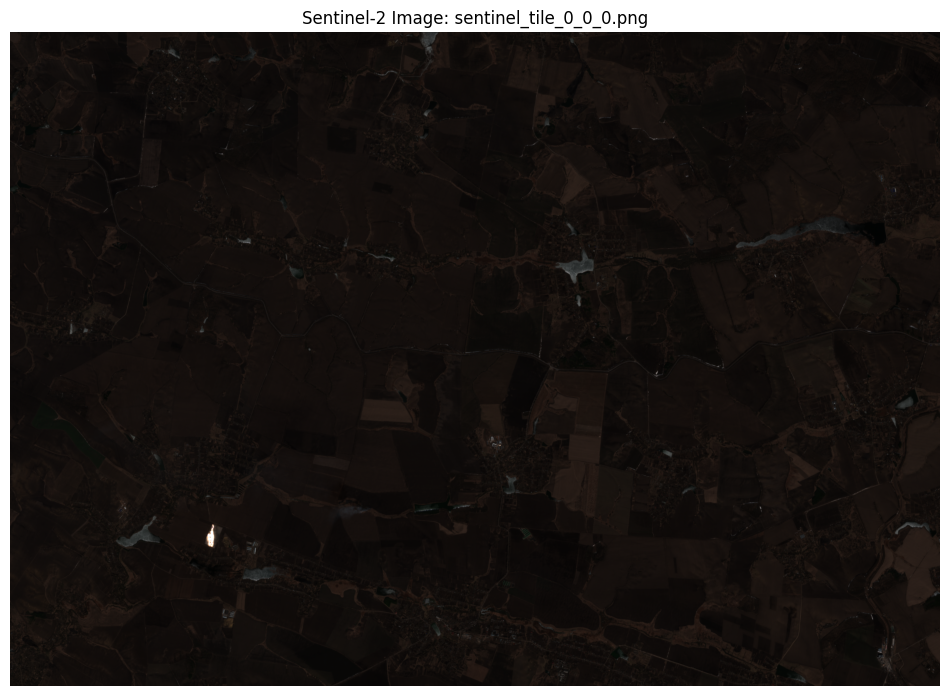

In [ ]:
processed_paths = process_sentinel_tiles(config, area, time_intervals, output_folder)

print(f"Total processed tiles: {len(processed_paths)}")

if processed_paths:
    img = Image.open(processed_paths[0])
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Sentinel-2 Image: {os.path.basename(processed_paths[0])}")
    plt.show()
else:
    print("No images were processed.")

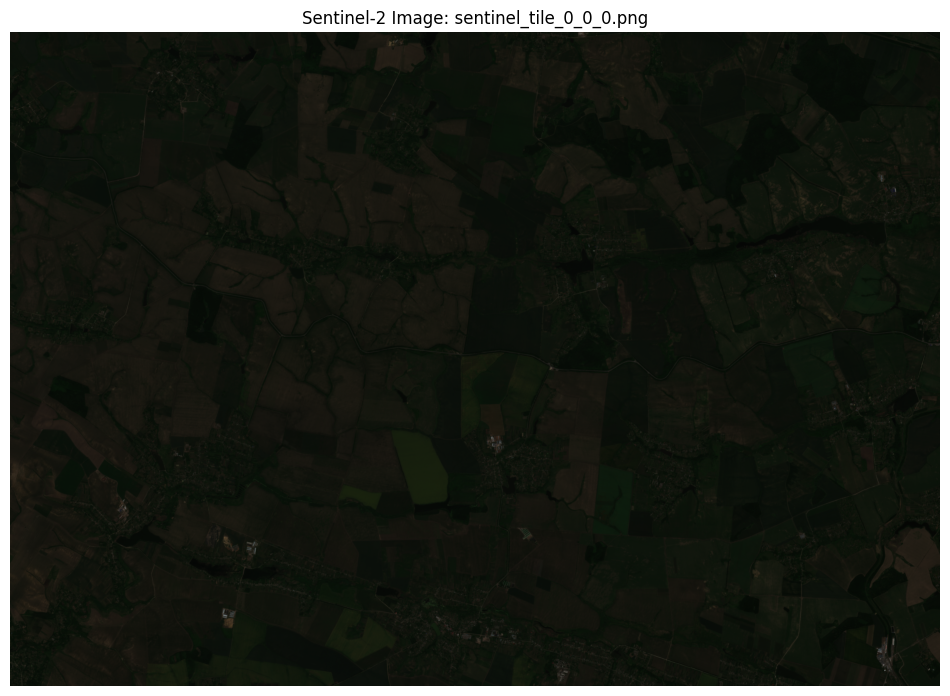

In [ ]:
img = Image.open(processed_paths[6])
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.title(f"Sentinel-2 Image: {os.path.basename(processed_paths[0])}")
plt.show()

Move the files to a permanent folder and delete the temporary one.

In [ ]:
def move_files(src_dir, dst_dir):
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)

    for filename in os.listdir(src_dir):
        src_file = os.path.join(src_dir, filename)
        dst_file = os.path.join(dst_dir, filename)
        shutil.move(src_file, dst_file)

    print(f"Files were moved from {src_dir} to {dst_dir}")

In [ ]:
move_files(output_folder, base_output_dir)

In [ ]:
shutil.rmtree(output_folder)
print(f"Temporary directory {output_folder} was deleted")

Function applies SIFT to an image and returns keypoints and descriptors.

In [ ]:
def apply_sift(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)

    return img, keypoints, descriptors

Function processes a dataset of images with SIFT, storing keypoints and descriptors for each image.

In [ ]:
def process_dataset_with_sift(dataset_dir):
    sift_results = {}
    for filename in os.listdir(dataset_dir):
        if filename.endswith('.png'):
            image_path = os.path.join(dataset_dir, filename)
            img, keypoints, descriptors = apply_sift(image_path)
            sift_results[filename] = {
                'image': img,
                'keypoints': keypoints,
                'descriptors': descriptors
            }
    return sift_results

In [ ]:
sift_results = process_dataset_with_sift(base_output_dir)

In [ ]:
for filename, result in sift_results.items():
    print(f"{filename}: {len(result['keypoints'])} keypoints")

sentinel_preview.png: 128 keypoints
sentinel_tile_0_0_0.png: 309 keypoints
sentinel_tile_0_0_1.png: 406 keypoints
sentinel_tile_0_1_0.png: 720 keypoints
sentinel_tile_0_1_1.png: 394 keypoints
sentinel_tile_0_2_0.png: 336 keypoints
sentinel_tile_0_2_1.png: 367 keypoints
sentinel_tile_1_0_0.png: 137 keypoints
sentinel_tile_1_0_1.png: 105 keypoints
sentinel_tile_1_1_0.png: 1077 keypoints
sentinel_tile_1_1_1.png: 135 keypoints
sentinel_tile_1_2_0.png: 218 keypoints
sentinel_tile_1_2_1.png: 40 keypoints
sentinel_tile_2_0_0.png: 14025 keypoints
sentinel_tile_2_0_1.png: 4881 keypoints
sentinel_tile_2_1_0.png: 56280 keypoints
sentinel_tile_2_1_1.png: 26330 keypoints
sentinel_tile_2_2_0.png: 36661 keypoints
sentinel_tile_2_2_1.png: 44579 keypoints


In [ ]:
def visualize_keypoints(image_path, keypoints):
    img = cv2.imread(image_path)
    img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img_with_keypoints

Get the first image from the SIFT results.
Visualize keypoints on the first image.
Display the image with keypoints.

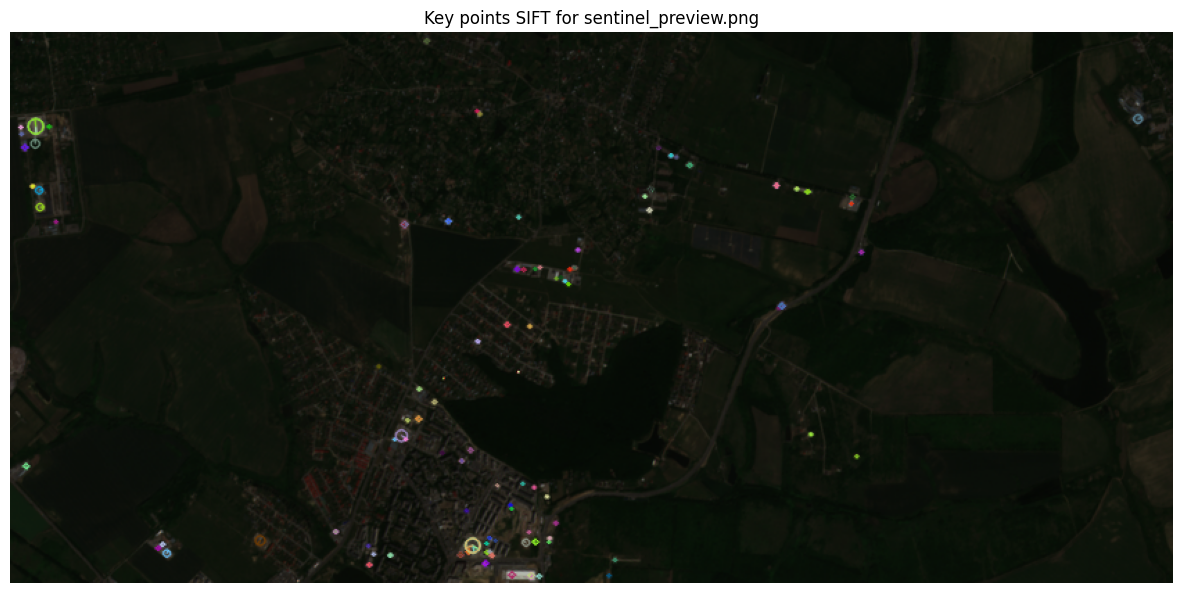

In [ ]:
first_image = next(iter(sift_results))
first_image_path = os.path.join(base_output_dir, first_image)
img_with_keypoints = visualize_keypoints(first_image_path, sift_results[first_image]['keypoints'])

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title(f"Key points SIFT for {first_image}")
plt.axis('off')
plt.show()

Function finds the most similar image to the query image using SIFT and BFMatcher.

In [ ]:
def find_most_similar_image(query_image_path, dataset_dir, sift_results):
    # Apply SIFT for query image
    query_img = cv2.imread(query_image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()
    query_keypoints, query_descriptors = sift.detectAndCompute(query_img, None)

    # Initialize FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    best_match = None
    max_good_matches = 0

    for filename, result in sift_results.items():
      # Find matches between descriptors
        matches = flann.knnMatch(query_descriptors, result['descriptors'], k=2)
        good_matches = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)
        if len(good_matches) > max_good_matches:
            max_good_matches = len(good_matches)
            best_match = (filename, good_matches)
    if best_match is None:
        return None, None, None, None

    best_match_img = sift_results[best_match[0]]['image']

    return best_match[0], query_img, best_match_img, best_match[1], query_keypoints


Function compare two images  using SIFT and BFMatcher, and visualizes the matches.

In [26]:


def compare_two_images(image1_path, image2_path):
    # Apply SIFT for both images
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    # Initialize FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Find matches between descriptors
    matches = flann.knnMatch(des1, des2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.9 * n.distance:
            good_matches.append(m)
    good_matches = sorted(good_matches, key = lambda x:x.distance)
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle("Comparison of Two Images")

    # Display the first image
    img1_color = cv2.cvtColor(cv2.imread(image1_path), cv2.COLOR_BGR2RGB)
    ax1.imshow(img1_color)
    ax1.set_title("Image 1", fontsize=14)
    ax1.axis('off')

    # Display the second image
    img2_color = cv2.cvtColor(cv2.imread(image2_path), cv2.COLOR_BGR2RGB)
    ax2.imshow(img2_color)
    ax2.set_title("Image 2", fontsize=14)
    ax2.axis('off')

    #Draw keypoints and lines between corresponding points
    for match in good_matches:
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx
        (x1, y1) = kp1[img1_idx].pt
        (x2, y2) = kp2[img2_idx].pt

        # Draw key points
        ax1.plot(x1, y1, 'ro', markersize=3)
        ax2.plot(x2, y2, 'ro', markersize=3)

        # Draw lines between corresponding points
        con = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA="data", coordsB="data",
                              axesA=ax1, axesB=ax2, color='yellow', linewidth=0.5)
        ax2.add_artist(con)

    plt.tight_layout()

    return fig, len(good_matches)


In [ ]:
query_image_path = "/content/drive/My Drive/Colab Notebooks/sentinel_dataset/sentinel_tile_0_1_1.png"
most_similar_image, query_img, best_match_img, matches, query_keypoints = find_most_similar_image(query_image_path, base_output_dir, sift_results)

Most similar image: sentinel_tile_0_1_1.png


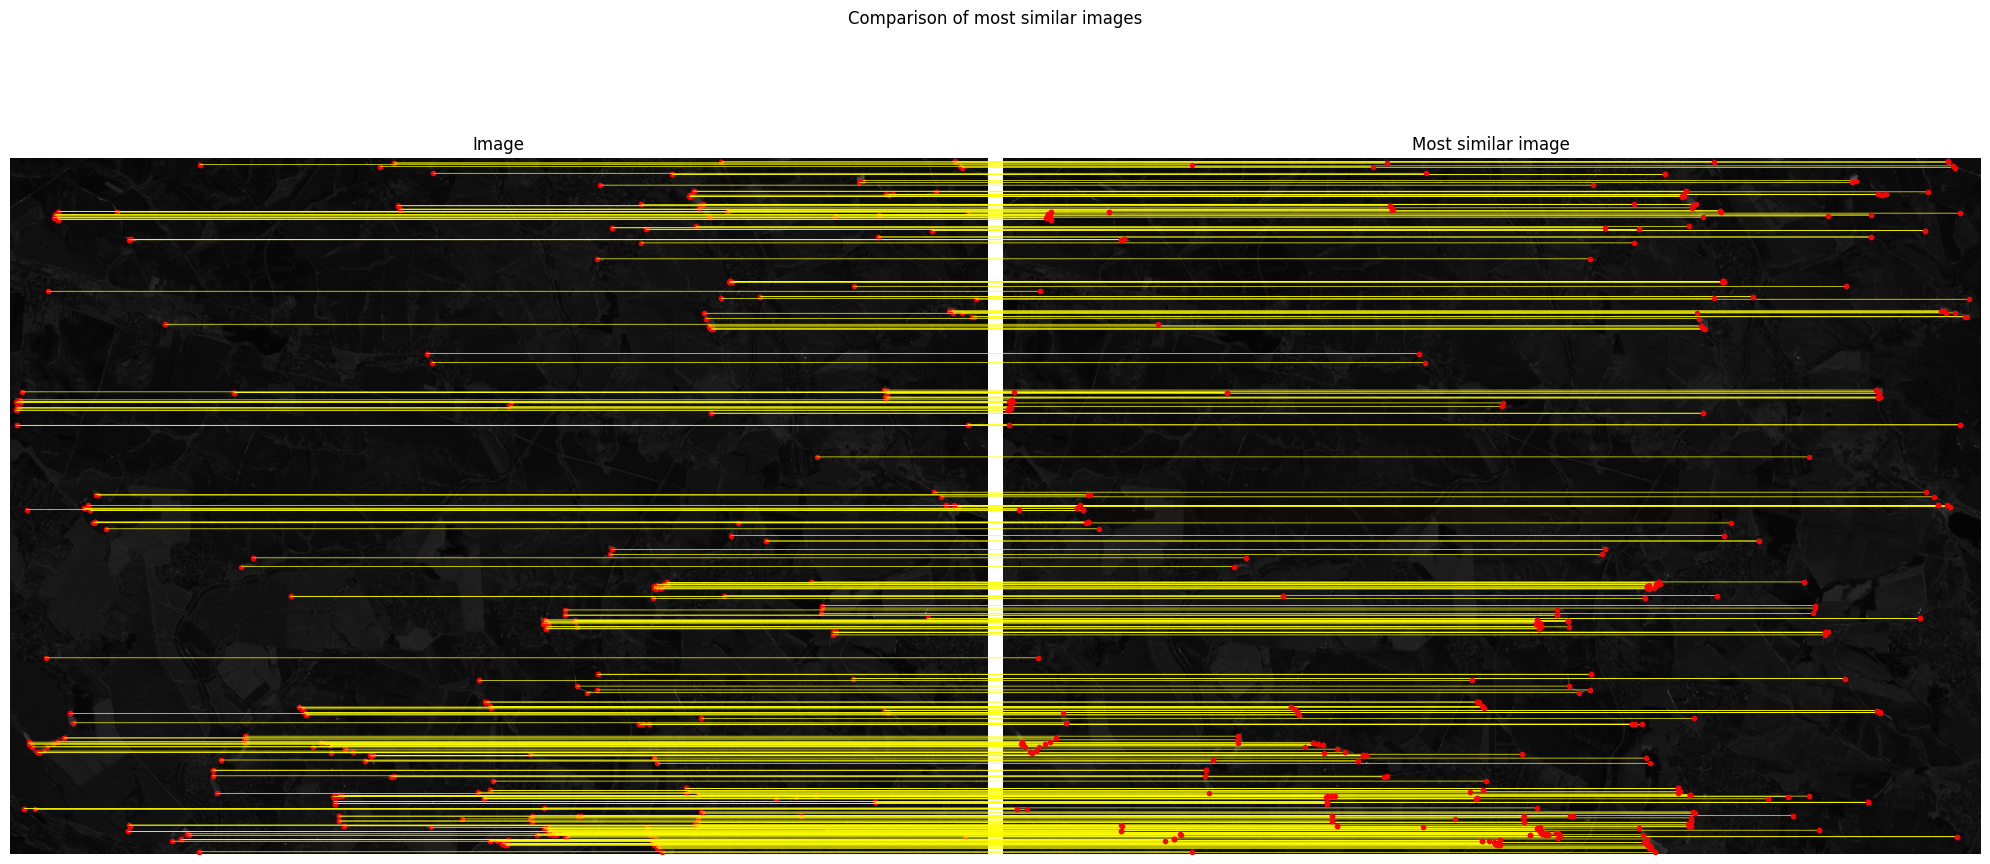

Quantity of matches: 394


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import cv2
import numpy as np

if most_similar_image:
    print(f"Most similar image: {most_similar_image}")

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle("Comparison of most similar images")

    # Display the first image
    ax1.imshow(cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB))
    ax1.set_title("Image")
    ax1.axis('off')

    # Display the second image
    ax2.imshow(cv2.cvtColor(best_match_img, cv2.COLOR_BGR2RGB))
    ax2.set_title("Most similar image")
    ax2.axis('off')

    # Draw keypoints and lines between corresponding points
    for match in matches:
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx
        (x1, y1) = query_keypoints[img1_idx].pt
        (x2, y2) = sift_results[most_similar_image]['keypoints'][img2_idx].pt

        # Draw key points
        ax1.plot(x1, y1, 'ro', markersize=3)
        ax2.plot(x2, y2, 'ro', markersize=3)

        # Draw lines between corresponding points
        con = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA="data", coordsB="data",
                              axesA=ax1, axesB=ax2, color='yellow', linewidth=0.5)
        ax2.add_artist(con)

    plt.tight_layout()
    plt.show()


    print(f"Quantity of matches: {len(matches)}")
else:
    print("No similar matches")

Quantity of matches: 22


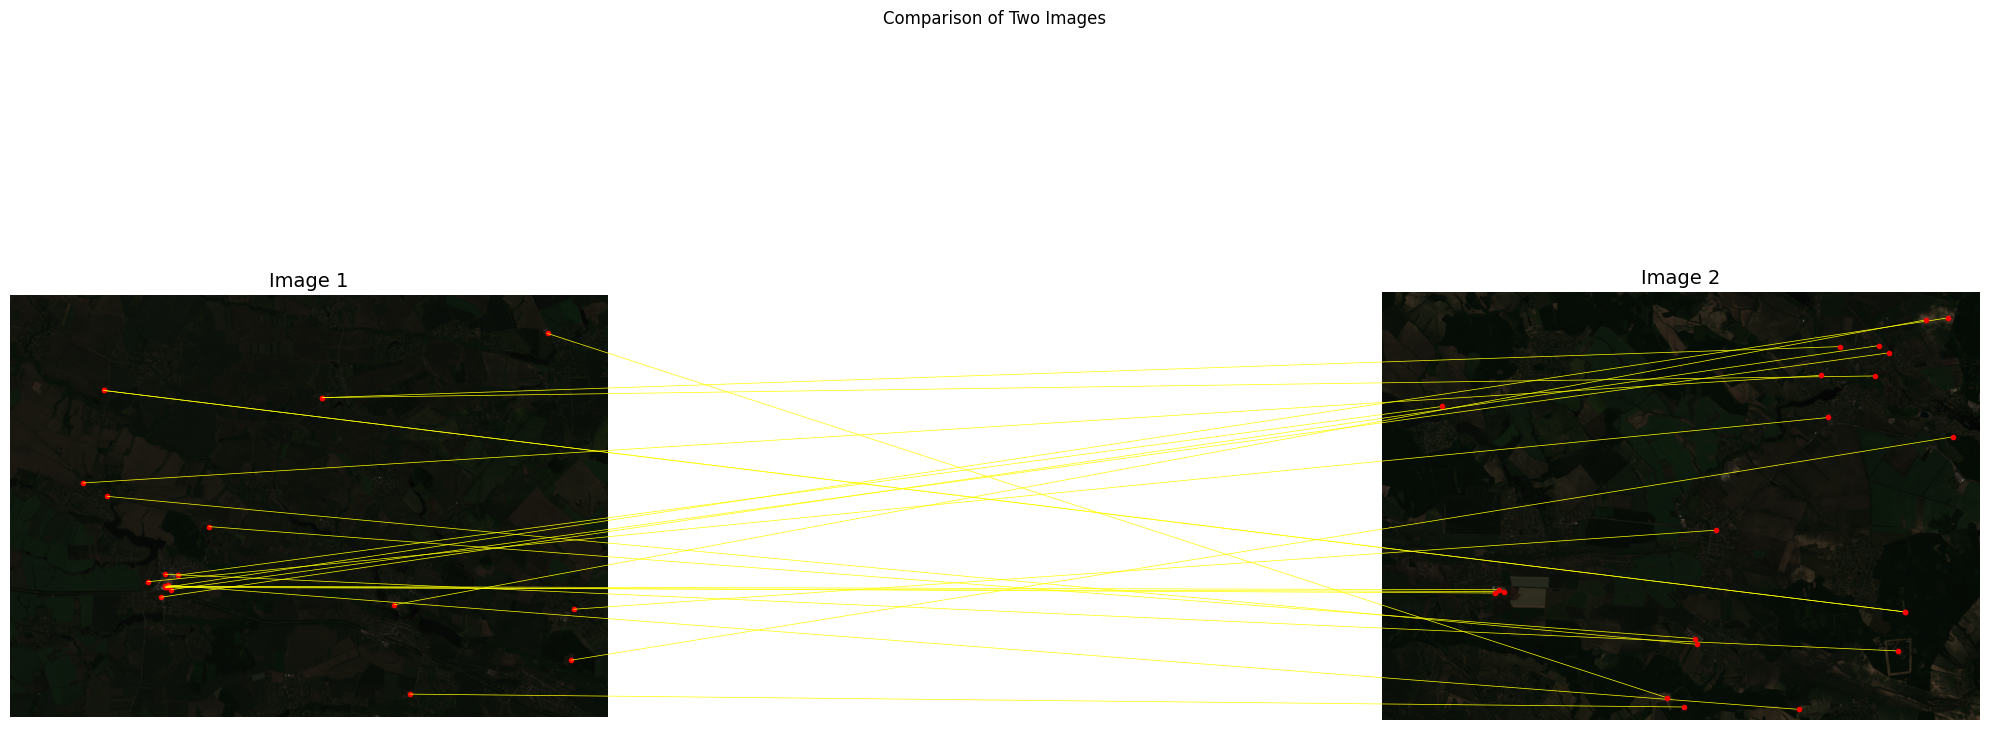

In [27]:
image1_path = "/content/drive/My Drive/Colab Notebooks/sentinel_dataset/sentinel_tile_1_0_1.png"
image2_path = "/content/drive/My Drive/Colab Notebooks/sentinel_dataset/sentinel_tile_1_2_0.png"
fig, num_matches = compare_two_images(image1_path, image2_path)
print(f"Quantity of matches: {num_matches}")

plt.show()

In [20]:
def compare_two_images2(image1_path, image2_path):
    # Apply SIFT for both images
    img1 = cv2.imread(image1_path)
    img2 = cv2.imread(image2_path)
    img1_1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_1 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1_1, None)
    kp2, des2 = sift.detectAndCompute(img2_1, None)

    # Initialize FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Find matches between descriptors
    matches = flann.knnMatch(des1, des2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.9 * n.distance:
            good_matches.append(m)
    good_matches = sorted(good_matches, key = lambda x:x.distance)
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches[:50], img2,
                                  flags=2)

    plt.figure(figsize=(20, 10))
    plt.imshow(img_matches)
    plt.title(f"Comparison of Two Images (Quantity of matches: {len(good_matches)})")
    plt.axis('off')
    plt.show()


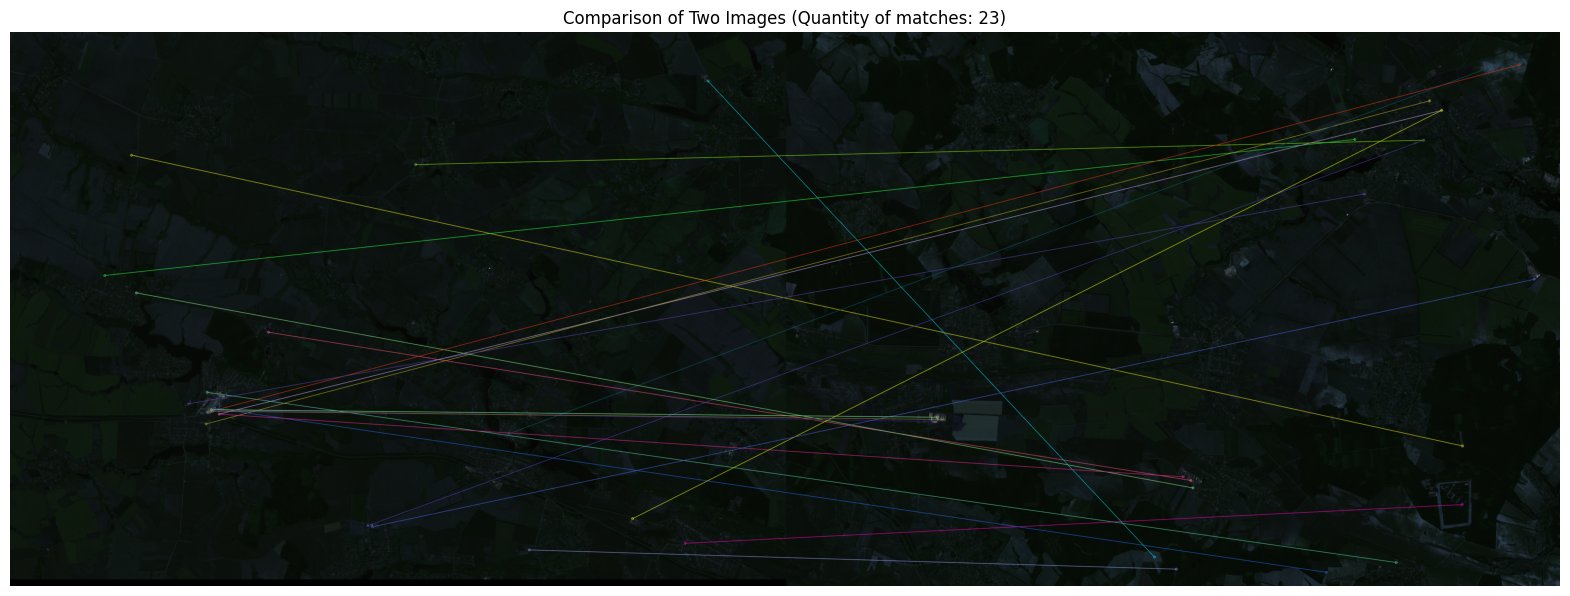

In [23]:
image1_path = "/content/drive/My Drive/Colab Notebooks/sentinel_dataset/sentinel_tile_1_0_1.png"
image2_path = "/content/drive/My Drive/Colab Notebooks/sentinel_dataset/sentinel_tile_1_2_0.png"
compare_two_images2(image1_path, image2_path)

